# Creating Fire Smoke Estimates

The common research question that we are answering is what are the estimated wildfire smoke impacts on your assigned city each year for the most recent 60 years of wildfire data. 

**Goal**  
You are to create an annual estimate of wildfire smoke in your assigned city. This estimate is just a number that you can eventually use to build a predictive model. Technically, smoke impact should probably be considered the health, tourism, economic or other social problems that result from the smoke. For this we'll generically call your estimate the wildfire smoke impact. You will consider other potential social and economic impacts during Part 2 of the course project. For now, you need some kind of number to represent an estimate of the smoke your city saw during each annual fire season.
Why is this an estimate of fire smoke? These are estimates because of a number of problems that are not easy to resolve combined with simplifications to make this course project reasonable for just a few weeks of work. One example is that an actual smoke impact would be based on wind direction over a course of several days, the intensity of the fire, and its duration. However, the fire polygon data only (reliably) provide a year for each fire - it does not (reliably) provide specific start and end dates for the fire. 

## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 16, 2024

The following pieces of code were used from Dr. David W. McDonald's notebook files.
1. API Request Template
2. `request_signup`
3. `request_list_info`
4. `request_daily_summary`


The rest of the code lies under the standard MIT license.

#### External Libraries

Uncomment the below cell to install and import the external dependencies from the following libraries - 
1. `pandas`
2. `numpy`
3. `matplotlib`
4. `sklearn`

In [ ]:
# ! pip install pandas
# !pip install numpy
# ! pip install matplotlib
# ! pip install sklearn

In [27]:
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Reading CSV file having the distance computations from the `data_acquisition.ipynb` notebook. 

Then, we try to filter the data to retain only the wildfires that have occured within 650 miles of Centennial, CO.

In [29]:
wildfire_df = pd.read_csv("intermediate_files/wildfires_with_distances.csv")
wildfire_df_within_650_miles = wildfire_df[wildfire_df['Min_Distance_Miles'] <= 650]
wildfire_df_within_650_miles.head()

C:\Users\navya\AppData\Local\Temp\ipykernel_19872\4218424440.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  wildfire_df = pd.read_csv("intermediate_files/wildfires_with_distances.csv")


,Unnamed: 0,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Listed_Fire_Types,...,Listed_Fire_Causes,Listed_Fire_Cause_Class,Listed_Rx_Reported_Acres,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Shape_Length,Shape_Area,Min_Distance_Miles
5,5,14605,14605,Wildfire,1964,1,"1 (2), 3 (4)",14101.443662,5706.651785,"Wildfire (4), Likely Wildfire (2)",...,Human (2),"Undetermined (4), Human (2)",NaN,NaN,NaN,0.245135,NaN,54086.991380,5.706652e+07,286.730967
7,7,14607,14607,Wildfire,1964,1,"1 (1), 3 (1)",11131.171732,4504.625381,Wildfire (2),...,NaN,Undetermined (2),NaN,NaN,NaN,0.323658,NaN,41820.660908,4.504625e+07,585.560801
8,8,14608,14608,Wildfire,1964,1,"1 (1), 3 (2)",10817.550376,4377.707322,"Wildfire (1), Likely Wildfire (2)",...,Unknown (2),Undetermined (3),NaN,NaN,NaN,0.166330,NaN,57509.990144,4.377707e+07,500.558777
13,13,14613,14613,Wildfire,1964,1,"1 (1), 3 (3)",5876.966587,2378.323998,"Wildfire (1), Likely Wildfire (3)",...,Unknown (3),Undetermined (4),NaN,NaN,NaN,0.169715,NaN,41964.322535,2.378324e+07,617.031596
14,14,14614,14614,Wildfire,1964,1,"1 (1), 3 (1)",4996.316663,2021.937618,Wildfire (2),...,NaN,Undetermined (2),NaN,NaN,NaN,0.994810,1.0,15981.540700,2.021938e+07,249.754960


Tried to use dates to get months and find wildfire months to weightage by but looks like most are in te months May to October and even the few that lie outside are small fires which get weighted out due to my formula anyways. 

In [30]:
print(f"The range within which the wildfires in the dataset occur is from {min(wildfire_df_within_650_miles['Min_Distance_Miles'])} to {max(wildfire_df_within_650_miles['Min_Distance_Miles'])}.")

The range within which the wildfires in the dataset occur is from 7.848867630134931 to 649.9772027611953.


In [31]:
wildfire_df_within_650_miles.columns

Index(['Unnamed: 0', 'OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type',
       'Fire_Year', 'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Listed_Fire_Types', 'Listed_Fire_Names',
       'Listed_Fire_Codes', 'Listed_Fire_IDs', 'Listed_Fire_IRWIN_IDs',
       'Listed_Fire_Dates', 'Listed_Fire_Causes', 'Listed_Fire_Cause_Class',
       'Listed_Rx_Reported_Acres', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Shape_Length', 'Shape_Area', 'Min_Distance_Miles'],
      dtype='object')

I am evaluating the utility of the `Listed_Fire_Dates` column. Based on the analysis conducted below, the organization of this column appears inconsistent. For earlier years, the entries are labeled as "Listed Wildfire Discovery Date," while in later years, they are referred to as "Listed Prescribed Fire End Date(s)." This inconsistency creates uncertainty about which date to utilize. Additionally, there are instances where the year in the `Fire Year` does not correspond to any entries in `Listed_Fire_Dates`. 

However, it is worth noting that the dates generally fall within the wildfire season from May to October. Ultimately, I decided not to use this field due to its unreliability and the limited value of the information it provides.

In [32]:
wildfire_df_within_650_miles[['Fire_Year', 'Listed_Fire_Dates']].head()

,Fire_Year,Listed_Fire_Dates
5,1964,Listed Wildfire Discovery Date(s): 1964-09-02 ...
7,1964,Listed Wildfire Discovery Date(s): 1964-08-16 ...
8,1964,Listed Wildfire Discovery Date(s): 1964-12-31 ...
13,1964,Listed Wildfire Discovery Date(s): 1964-08-23 ...
14,1964,Listed Other Fire Date(s): 2018-05-02 - NIFC D...


In [33]:
from pprint import pprint
pprint(wildfire_df['Listed_Fire_Dates'][1])

('Listed Wildfire Discovery Date(s): 1964-09-19 (2) | Listed Wildfire '
 'Containment Date(s): 1964-09-19 (1) | Listed Other Fire Date(s): 1899-12-30 '
 '- REVDATE field (1), 1964-09-19 - DATE_CUR field (1)')


In [34]:
pprint(wildfire_df['Listed_Fire_Dates'][10000])

('Listed Wildfire Discovery Date(s): 1983-07-28 (1) | Listed Wildfire '
 'Controlled Date(s): 1983-07-28 (1) | Listed Wildfire Out Date(s): 1983-07-29 '
 '(1) | Listed Other Fire Date(s): 2017-03-13 - NIFC DATE_CUR field (1) | '
 'Listed Upload Date(s): 2013-02-04 (1)')


In [35]:
pprint(wildfire_df['Listed_Fire_Dates'][100000])

('Listed Prescribed Fire End Date(s): 2013-11-19 (1) | Listed Upload Date(s): '
 '2010-07-20 (1)')


In [36]:
pprint(wildfire_df['Fire_Year'][100000])

2013


In [37]:
pprint(wildfire_df['Listed_Fire_Dates'][50010])
pprint(wildfire_df['Fire_Year'][50010])

('Listed Wildfire Discovery Date(s): 2014-07-23 (1) | Listed Other Fire '
 'Date(s): 2017-10-11 - NIFC DATE_CUR field (1), 2017-10-11 - REVDATE field '
 '(1)')
2014


In [38]:
wildfire_df_within_650_miles['Assigned_Fire_Type'].unique()

array(['Wildfire', 'Unknown - Likely Wildfire', 'Likely Wildfire',
       'Unknown - Likely Prescribed Fire', 'Prescribed Fire'],
      dtype=object)

## Smoke Impact Estimation Model: Technical Analysis and Justification

This section provides a methodology and justification for a smoke impact estimation formula developed to quantify the effects of wildfire smoke. In this model, I aim to incorporate multiple physical and empirical factors to produce a standardized impact score on a scale from 0 to 100.

#### Size Factor
**Formula**: `size_factor = np.log1p(acres) / np.log1p(1000)`

The variable `acres` represents the total area of the fire perimeter measured in acres. It is a primary indicator of fire magnitude, directly correlating with smoke production volume and potential environmental impact. 

I decided to use a logarithmic transformation to handle a wide range of values, addressing the non-linear relationship between size and smoke production. This normalization to a 1000-acre reference point allows for more meaningful comparisons. The `np.log1p` function appropriately handles zero values, ensuring robust calculations. [Reference to learn more about logarithmic transformations in environmental science](https://www.sciencedirect.com/science/article/abs/pii/S0306261918300030).

#### Shape Length and Shape Area to Estimate Fire Duration
**Formula**: `duration_factor = min(30, sqrt(shape_area) / (shape_length / 1000))`

In this formula, `shape_length` denotes the perimeter of the fire boundary, while `shape_area` refers to the total area enclosed by that boundary. I utilized these variables as indicators of fire spread patterns, which can be useful for estimating burn duration. This insight could also help in estimating the temporal impact of the fire. To maintain realism, I set a maximum duration of 30 days to reflect typical fire duration limits. [Reference to learn more about the relationship between fire behavior and duration](https://www.fs.usda.gov/rm/pubs/rmrs_p046/rmrs_p046_14.pdf).

#### Circleness Scale
**Formula**: `intensity_factor = 0.5 + Circleness_Scale / 2`

The `circleness scale` measures the circularity of the fire perimeter, ranging from 0 to 1, with 1 being most circular and 0 being least. Research suggests that circular fires typically exhibit more intense burning compared to non-circular ones, likely due to uniform fuel conditions and consistent wind patterns. This insight leads me to believe that the shape of the fire perimeter influences overall smoke production estimates. I scaled the result to a range from 0.5 to 1.5 to ensure meaningful differentiation. [Reference to learn more about more about fire geometry and intensity](https://www.researchgate.net/publication/313221390_A_Quantitative_Method_for_Estimation_of_Fire_Behavior_Using_Fire_Geometry).

#### Fire Classification Variable

I used the categorical variable using the `Assigned_Fire_Type` field which was based on the fire origin and management status.
Based on some domain knowledge, and readings I did, I decided to use the below scale -   

**Scale**:
- Wildfire: 5
- Likely Wildfire: 4
- Prescribed Fire: 3
- Unknown: 3
- Other: 1   
I have given higher weights for uncontrolled wildfires and lower weights for managed burns.
Reference: [Reference to learn more about National Wildfire Coordinating Group Glossary of Terms](https://www.nwcg.gov/term/glossary) 

#### Distance Decay Factor
**Formula**: `distance_factor = 1 / (1 + (distance / 50) ** 2)`

In this context, `distance` refers to the shortest distance from the fire to a point of interest (Centennial, CO). I included this factor because I believe it is inversely related to smoke impact. Given that Centennial is where a significant portion of the population resides, the impact is likely less pronounced the further one is from these coordinates. This model employs a quadratic decay to accurately reflect the reduction in smoke concentration and impact as distance increases. My approach was refined through trial and error to determine effective constants. [Reference to learn more about distance decay in environmental modeling](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4202337/).

#### 4.1 Final Calculation
`smoke_impact = size_factor * distance_factor * intensity_factor * duration_factor * fire_intensity_factor`

The final calculation combines these factors multiplicatively to capture interaction effects. I scaled the result from 0 to 100 for a more intuitive interpretation of the smoke impact.

### Model Parameters
Additionally, I manually configured some model parameters based on domain knowledge. I set the **distance_threshold** to 650 miles, as specified in the problem statement, and the **season_duration** to 120 days, which is typically how long the wildfire season lasts in the U.S.

### Acknowledging Limitations
While I have endeavored to incorporate many variables into my formula for estimating smoke impact, I recognize the limitations of my approach. Here are a few aspects that could improve the accuracy of the smoke estimate:
- The simplified treatment of atmospheric dynamics and the absence of direct weather effects; integrating weather data could enhance accuracy.
- Temporal resolution limitations due to averaging over days, which may obscure important trends; developing capabilities for higher temporal resolution is advisable.
- Further refinement of intensity proxies could yield better estimates.
- Validation against actual air quality measurements would strengthen the model's reliability.

#### Potential Additional Variables
- Fuel type and loading
- Terrain complexity metrics
- Weather conditions
- Vegetation density



In [39]:

def calculate_smoke_impact(
    fire_data,
    reference_year=None,
    distance_threshold=650,  # miles
    season_duration=120,      # typical fire season duration in days
    population_exposure=None  # optional dict of city populations
):
    """
    Calculate estimated smoke impact from wildfire data.
    
    Parameters:
    fire_data: DataFrame containing fire information
    reference_year: Year to filter data (optional)
    distance_threshold: Maximum distance to consider fires (in miles)
    season_duration: Duration of fire season in days
    population_exposure: Dict of city populations for weighted impact
    
    Returns:
    Dictionary containing smoke impact metrics by year
    """
    
    def calculate_single_fire_impact(row):
        # Base intensity factors
        acres = row['GIS_Acres']
        distance = row['Min_Distance_Miles']
        
        # Ignore fires beyond threshold
        if distance > distance_threshold:
            return 0
        
        # Basic smoke calculation components
        
        # 1. Size Impact: Larger fires produce more smoke
        size_factor = np.log1p(acres) / np.log1p(1000)  # normalized to 1000 acres
        
        # 2. Distance Decay: Smoke dissipates with distance
        distance_factor = 1 / (1 + (distance / 50) ** 2)  # 50 mile reference distance
        
        # 3. Fire Intensity Proxy: Using circleness as a rough proxy for intensity
        intensity_factor = 1.0
        if 'Circleness_Scale' in row and not pd.isna(row['Circleness_Scale']):
            intensity_factor = 0.5 + row['Circleness_Scale'] / 2
        
        # 4. Duration Factor: Estimate duration using Shape_Length and Shape_Area
        if 'Shape_Length' in row and 'Shape_Area' in row:
            try:
                shape_length = row['Shape_Length']
                shape_area = row['Shape_Area']
                # Estimate duration (days) as a function of perimeter and area
                # This formula assumes larger fires with compact perimeters burn longer
                duration_factor = min(30, np.sqrt(shape_area) / (shape_length / 1000))  # Normalize to 30 days max
            except:
                duration_factor = 1.0  # Default if shape data can't be parsed
        else:
            duration_factor = 1.0  # Default if shape data is missing
        

        # Fire Intensity Factor
        if 'Assigned_Fire_Type' == "Wildfire":
            fire_intensity_factor = 5
        elif 'Assigned_Fire_Type' == "Likely Wildfire":
            fire_intensity_factor = 4
        elif 'Assigned_Fire_Type' == "Prescribed Fire":
            fire_intensity_factor = 5
        elif 'Assigned_Fire_Type' == "Unknown - Wildfire":
            fire_intensity_factor = 3
        else:
            fire_intensity_factor = 1

        
        # Combine factors into final smoke impact score
        smoke_impact = (
            size_factor *
            distance_factor *
            intensity_factor *
            duration_factor*
            fire_intensity_factor
        )
        
        # Scale to a more intuitive range (0-100)
        smoke_impact = min(100, smoke_impact * 20)
        
        return smoke_impact
    
    # Calculate impact for each fire
    impacts = {}
    
    for _, row in fire_data.iterrows():
        year = row['Fire_Year']
        if reference_year and year != reference_year:
            continue
            
        impact = calculate_single_fire_impact(row)
        
        if year not in impacts:
            impacts[year] = {
                'total_impact': 0,
                'peak_daily_impact': 0,
                'num_fires': 0,
                'total_acres': 0
            }
        
        impacts[year]['total_impact'] += impact
        impacts[year]['peak_daily_impact'] = max(
            impacts[year]['peak_daily_impact'],
            impact / season_duration
        )
        impacts[year]['num_fires'] += 1
        impacts[year]['total_acres'] += row['GIS_Acres']
        
    # Calculate additional metrics for each year
    for year in impacts:
        impacts[year]['average_impact_per_fire'] = (
            impacts[year]['total_impact'] / impacts[year]['num_fires']
            if impacts[year]['num_fires'] > 0 else 0
        )
        impacts[year]['impact_density'] = (
            impacts[year]['total_impact'] / impacts[year]['total_acres']
            if impacts[year]['total_acres'] > 0 else 0
        )
        
    return impacts

The provided code snippet calculates the smoke impact for each year from 1964 to 2024 based on wildfire data within a 650-mile radius. For each year, it calls the `calculate_smoke_impact` function, passing in the wildfire data and the current year as the reference year. If the results for that year exist, the corresponding impact data is extracted, and the year is added to the data as a new field.

In [40]:
impact_results = []

# Loop through each year and calculate smoke impacts
for year in range(1964, 2025):  # Loop from 1964 to 2024
    results = calculate_smoke_impact(wildfire_df_within_650_miles, reference_year=year)
    
    if year in results:  # Check if there is data for the given year
        impact_data = results[year]
        impact_data['Year'] = year  # Add the year to the impact data
        impact_results.append(impact_data)
        print(f"Completed for year {year}...")

# Convert list of dictionaries to a DataFrame
impact_df = pd.DataFrame(impact_results)

# Display the resulting DataFrame
impact_df.head()

Completed for year 1964...
Completed for year 1965...
Completed for year 1966...
Completed for year 1967...
Completed for year 1968...
Completed for year 1969...
Completed for year 1970...
Completed for year 1971...
Completed for year 1972...
Completed for year 1973...
Completed for year 1974...
Completed for year 1975...
Completed for year 1976...
Completed for year 1977...
Completed for year 1978...
Completed for year 1979...
Completed for year 1980...
Completed for year 1981...
Completed for year 1982...
Completed for year 1983...
Completed for year 1984...
Completed for year 1985...
Completed for year 1986...
Completed for year 1987...
Completed for year 1988...
Completed for year 1989...
Completed for year 1990...
Completed for year 1991...
Completed for year 1992...
Completed for year 1993...
Completed for year 1994...
Completed for year 1995...
Completed for year 1996...
Completed for year 1997...
Completed for year 1998...
Completed for year 1999...
Completed for year 2000...
C

,total_impact,peak_daily_impact,num_fires,total_acres,average_impact_per_fire,impact_density,Year
0,537.607046,0.294440,138,113354.820507,3.895703,0.004743,1964
1,235.333729,0.117670,100,45581.443461,2.353337,0.005163,1965
2,495.438609,0.279405,170,353280.478901,2.914345,0.001402,1966
3,312.113945,0.212278,98,31594.223456,3.184836,0.009879,1967
4,206.553770,0.155622,85,40769.663532,2.430044,0.005066,1968


Reading the annual AQI Dataframe created in the `epa_air_quality_history_example.ipynb` notebook.

In [47]:
aqi_df = pd.read_csv("intermediate_files/aqi_yearly.csv")
aqi_df = aqi_df.reset_index()

print("Columns:",aqi_df.columns)

aqi_df.head()

Columns: Index(['index', 'Unnamed: 0', 'Year', 'average_aqi', 'average_aqi_scaled'], dtype='object')


,index,Unnamed: 0,Year,average_aqi,average_aqi_scaled
0,0,0,1978,55.601504,0.395016
1,1,1,1979,67.342391,0.666885
2,2,2,1980,49.010929,0.242407
3,3,3,1981,64.347826,0.597544
4,4,4,1982,70.184783,0.732703


This segment of code focuses on scaling and visualizing smoke impact estimates and air quality index (AQI) data over time. First, it employs the `MinMaxScaler` from scikit-learn to scale the `total_impact` values from the `impact_df` DataFrame and the `average_aqi` values from the `aqi_df` DataFrame to a normalized range of [0, 1]. This ensures that both metrics are comparable in magnitude. The code then merges these scaled values into a single DataFrame, `merged_df`, based on the "Year" column, using an outer join to retain all available years from both datasets. To ensure continuity, a complete list of years from 1964 to 2024 is created and merged with `merged_df`, filling any gaps in the data. 

Finally, the code visualizes the scaled smoke estimates and average AQI values using a line plot, setting appropriate labels and legends to clearly convey the comparison between the two metrics over the specified years. The x-axis is configured to display ticks for every five years.

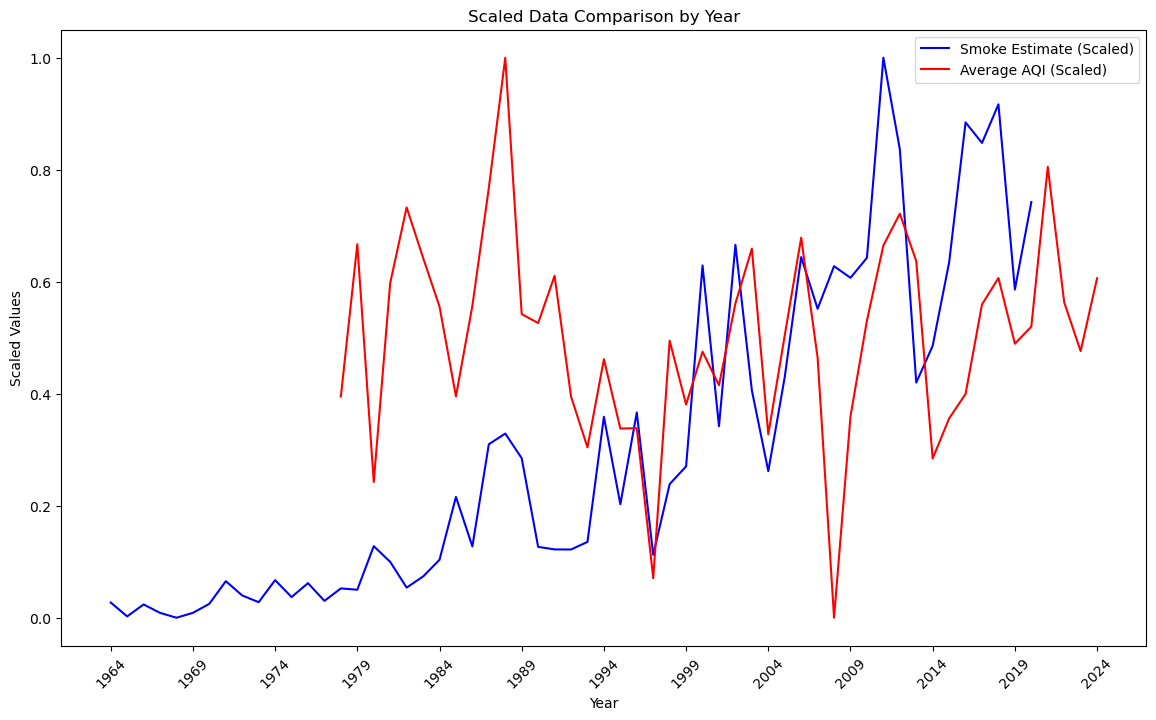

In [44]:
# Scale the 'total_impact' and 'average_aqi' columns to a [0, 1] range using MinMaxScaler
scaler = MinMaxScaler()

# Transform the 'total_impact' column from impact_df into a new column 'smoke_estimate'
impact_df['smoke_estimate'] = scaler.fit_transform(impact_df[['total_impact']])

# Transform the 'average_aqi' column from aqi_df into a new column 'average_aqi_scaled'
aqi_df['average_aqi_scaled'] = scaler.fit_transform(aqi_df[['average_aqi']])

# Merge the scaled values from both DataFrames on the 'Year' column,
# using an outer join to ensure all years from both DataFrames are included
merged_df = pd.merge(
    impact_df[['Year', 'smoke_estimate']], 
    aqi_df[['Year', 'average_aqi_scaled']], 
    on='Year', 
    how='outer'
)

# Create a DataFrame containing a complete list of years from 1964 to 2024
full_years = pd.DataFrame({'Year': range(1964, 2025)})

# Merge the complete years DataFrame with merged_df to fill in any missing years
merged_df = pd.merge(full_years, merged_df, on='Year', how='left')

# Initialize a plot with specified dimensions for better visibility
plt.figure(figsize=(14, 8))

# Plot the scaled smoke impact estimates over the years in blue
plt.plot(merged_df['Year'], merged_df['smoke_estimate'], color='blue', label='Smoke Estimate (Scaled)')

# Plot the scaled average AQI values over the years in red
plt.plot(merged_df['Year'], merged_df['average_aqi_scaled'], color='red', label='Average AQI (Scaled)')

# Set the x-axis ticks to display every year from 1964 to 2024,
# rotating labels for improved readability
plt.xticks(range(1964, 2025, 5), rotation=45)  # Change the interval to 1 if you want every year

# Set the labels for the x-axis and y-axis, along with the plot title
plt.xlabel('Year')
plt.ylabel('Scaled Values')
plt.title('Scaled Data Comparison by Year')

# Add a legend to distinguish between the two plotted lines
plt.legend()

# Display the plot
plt.show()

Interesting! It looks like for the later years, 1994-2024, both the smoke estimate values and the scales AQI values seem to be cloesly related or atleast show similar trends and peaks (except for the one outlier in 2008). The corrwltion seems to be off fomr the decates from 1974 to 1994, but agaion, we still see the similarity in the trends also it's offset by a huge y-constant. 

### Attempting to explain this discrepancy


The outlier in 2008-2009, where the smoke estimate shows a noticeable spike, could be attributed to several possible factors affecting air quality specifically around Centennial, Colorado. One likely cause is the **intense wildfire season across the western United States** in 2008. Although Centennial is not directly in a high-wildfire zone, the state of Colorado and surrounding areas often experience substantial air quality impacts from wildfires in nearby states like California, Arizona, and Utah. In 2008, California, for example, experienced a particularly severe fire season, and smoke from these fires could have drifted eastward, impacting Colorado's air quality ([source](https://www.nytimes.com/2008/07/01/us/01wildfire.html)). This could've caused the discrepancy we notice in the graph between the AQI and smoke estimate values. Our smoke estimate gives us an idea about the impact only during wildfire season wheras AQI could be affected by multiple factors.
 **AQI readings could have been affected by local non-smoke-related pollutants**, such as emissions from transportation, industrial activity, or even local energy production. This period coincided with the onset of the Great Recession, which caused fluctuations in industrial activity that may have temporarily altered pollution levels in unpredictable ways, potentially leading to this AQI spike even if smoke levels didn't correspondingly increase ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4377868/)).


The low correlation between smoke estimates and AQI from 1974 to 1990 likely reflects a few regional and historical factors. During this period, **wildfires were generally less frequent and less intense** due to different land management practices across Colorado and surrounding states. The federal and state governments typically used aggressive fire suppression techniques to contain wildfires quickly, which likely resulted in lower smoke emissions overall. This approach prevented smaller, frequent burns and led to a gradual buildup of flammable vegetation over time. This buildup, combined with warming temperatures, has contributed to the recent increase in large, intense wildfires ([source](https://www.pnas.org/doi/full/10.1073/pnas.1708916114)).

In addition, **AQI values in this period may have been more strongly influenced by urban pollution sources**, such as vehicle emissions and industrial activities. Centennial is part of the Denver metropolitan area, and during the late 20th century, this region experienced significant urbanization and industrial growth ([source](https://www.theguardian.com/environment/2018/oct/21/denver-colorado-air-quality-pollution)). Emissions from transportation and industrial activity may have played a larger role in AQI values, making AQI less reflective of smoke in this period.

Lastly, **advances in air quality monitoring technology and data collection practices** could explain some of the discrepancies. In the 1970s and 1980s, air quality monitoring methods were less sophisticated, with fewer stations and less precise measurements. The AQI data from this time may not accurately reflect smoke contributions due to these limitations, whereas more recent measurements are more likely to capture the full spectrum of airborne pollutants ([source](https://www.epa.gov/air-trends/air-quality-improvements-1970-2020)).
